(ttv)=

# Fitting for Transit Timing Variations (TTVs)

Similarly to [exoplanet](https://docs.exoplanet.codes/en/latest/), `jaxoplanet` contains the ability to model transit timing variations for planetary systems. This tutorial follows from [Fitting Transit Times](https://gallery.exoplanet.codes/tutorials/ttv/) from the [exoplanet](https://docs.exoplanet.codes/en/latest/) Python package.

```{note}
This tutorial requires some [extra packages](about.ipynb) that are not included in the `jaxoplanet` dependencies.
```

## Setup

We first setup the number of CPUs to use and enable the use of double-precision numbers with jax.

In [1]:
import jax
import numpyro

numpyro.set_host_device_count(2)
jax.config.update("jax_enable_x64", True)

## Generating the data

Let's generate the light curve of a two-planet system featuring transit time variations.

[TTVOrbit](jaxoplanet.orbits.ttv.TTVOrbit) is an orbit object parameterized by the observables of a transiting system with transit time variations. On top of the [TransitOrbit](jaxoplanet.orbits.transit.TransitOrbit) parameters, this orbit can be instantiating with a list of `transit_times`, omitting the need for a period and time of transit.

This is what our data model will look like

In [2]:
from jaxoplanet.orbits.ttv import TTVOrbit
from jaxoplanet.light_curves import limb_dark_light_curve


def orbit_and_lightcurve_model(time, params):
    transit_times = (params[f"transit_times_{i}"] for i in range(len(params["b"])))
    orbit = TTVOrbit(
        transit_times=transit_times,
        duration=params["duration"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return orbit, limb_dark_light_curve(orbit, params["u"])(time)

Using the [compute_expected_transit_times](jaxoplanet.orbits.ttv.compute_expected_transit_times) function, we can compute the expected transits of the system given the orbital parameters of the two planets.

In [3]:
import numpy as np
import jax.numpy as jnp
from jaxoplanet.orbits.ttv import compute_expected_transit_times

random = np.random.default_rng(11)

# true parmaters of the system
time = jnp.arange(0, 30, 0.05)  # day
true_periods = jnp.array([3, 6])  # day
true_t0s = jnp.array([2, 3])  # day

# computing expected transit times
expected_transit_times = compute_expected_transit_times(
    time.min(), time.max(), true_periods, true_t0s
)
n_planets = len(expected_transit_times)
planet_indices = jnp.arange(n_planets)
offset_factors = (3 / 24) - (planet_indices % 2) * 0.1
true_ttvs = []

for i, tt in enumerate(expected_transit_times):
    ttv = offset_factors[i] * jnp.sin(2 * jnp.pi * tt / 17)
    true_ttvs.append(ttv)

true_transit_times = tuple(
    tt + ttv for tt, ttv in zip(expected_transit_times, true_ttvs)
)

truth = {
    "transit_times_0": true_transit_times[0],
    "transit_times_1": true_transit_times[1],
    "b": jnp.array([0.5, 0.5]),
    "duration": jnp.array([0.5, 0.3]),
    "u": jnp.array([0.1, 0.06]),
    "r": jnp.array([0.1, 0.07]),
}

We can now generate and plot our data

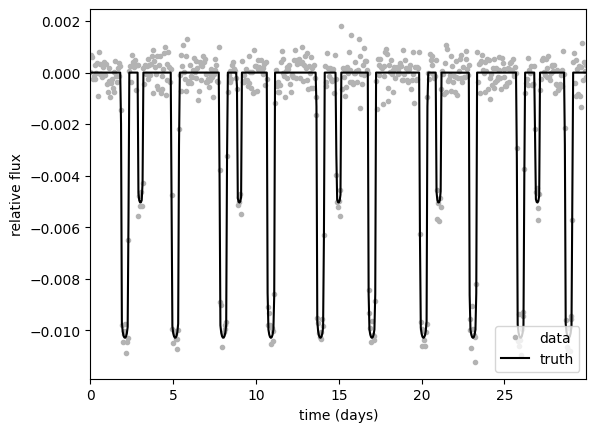

In [4]:
import matplotlib.pyplot as plt

yerr = 5e-4
y_true_all = orbit_and_lightcurve_model(time, truth)[1]
y_true = jnp.sum(y_true_all, axis=-1)
y = jnp.array(y_true + yerr * random.normal(size=len(time)))

# Let's see what the light curve looks like
plt.plot(time, y, ".", c="0.7", label="data")
plt.plot(time, y_true, label="truth", c="k")
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
_ = plt.legend(loc=4)

## Model with NumPyro

We will now instantiate a NumPyro model in order to infer the properties of the system from the generated data. 

Everything here is quite standard, but in the instance of a multi-planet system, we can supply a `jax.numpy` array of values for our priors,
and we can apply the method [to_event](https://num.pyro.ai/en/latest/distributions.html#numpyro.distributions.distribution.Distribution.to_event) in order to tell Numpyro the dimensions are independent,
that is, the period of planet 1 does not depend on the period of planet 2. 

In [5]:
import numpyro_ext
import jax.numpy as jnp


def model(time, yerr, y=None):

    # For loop to account for each planet's transit times, with a Uniform prior
    # centered on the true transit times and lower/upper limits of 1 day.
    transit_times = []
    for i in range(2):
        transit_times.append(
            numpyro.sample(
                f"transit_times_{i}",
                numpyro.distributions.Uniform(
                    low=true_transit_times[i] - 1.0, high=true_transit_times[i] + 1.0
                ),
            )
        )

    # The duration
    logD = numpyro.sample(
        "logD",
        numpyro.distributions.Normal(jnp.log(truth["duration"]), 0.1).to_event(1),
    )
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # The radius ratio
    logR = numpyro.sample(
        "logR", numpyro.distributions.Normal(jnp.log(truth["r"]), 0.1).to_event(1)
    )
    r = numpyro.deterministic("r", jnp.exp(logR))

    # The impact parameter, note, for multi-planet systems, we need to pass in a
    # jax numpy array of values
    _b = numpyro.sample(
        "_b",
        numpyro.distributions.Uniform(
            low=jnp.array([0.0, 0.0]), high=jnp.array([1.0, 1.0])
        ).to_event(1),
    )
    b = numpyro.deterministic("b", _b * (1 + r))

    # The limb darkening coefficients
    u = numpyro.sample("u", numpyro_ext.distributions.QuadLDParams())

    params = {
        "b": b,
        "u": u,
        "r": r,
        "duration": duration,
        "transit_times_0": transit_times[0],
        "transit_times_1": transit_times[1],
    }

    orbit, y_pred_all = orbit_and_lightcurve_model(time, params)
    y_pred = jnp.sum(y_pred_all, axis=-1)

    # Here are some useful under the radar variables that we can access from TTVOrbit.
    # These are the linear ephemeris parameters and the TTVs.
    for i in range(2):
        numpyro.deterministic(f"t0_{i}", orbit.linear_t0[i])
        numpyro.deterministic(f"period_{i}", orbit.linear_period[i])
        numpyro.deterministic(f"ttvs_{i}", orbit.ttvs[i])

    # The likelihood function assuming Gaussian uncertainty
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

As in the the [Fitting Transit Times](./transit.ipynb) tutorial, it might be a good idea to check the priors of your model.

## Optimization

We will now optimize our model in preparation of sampling the posterior likelihood of the data

In [6]:
init_params = {
    **truth,
    "logD": jnp.log(truth["duration"]),
    "logR": jnp.log(truth["r"]),
    "_b": truth["b"] / (1 + truth["r"]),
}

run_optim = numpyro_ext.optim.optimize(
    model,
    init_strategy=numpyro.infer.init_to_value(values=init_params),
)

opt_params = run_optim(jax.random.PRNGKey(5), time, yerr, y=y)

Let's plot the MAP model against the simulated data.

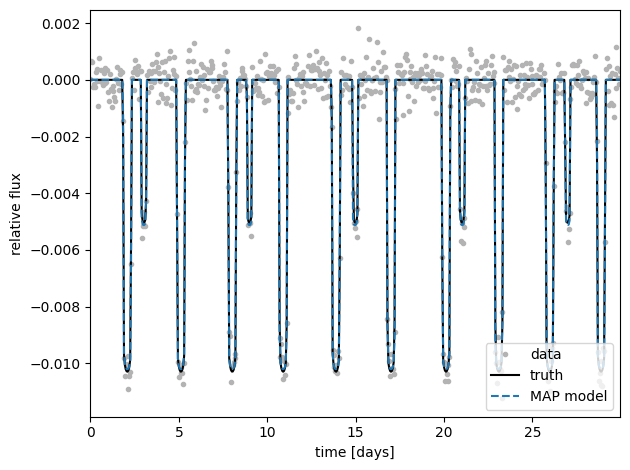

In [7]:
_, map_light_curve = orbit_and_lightcurve_model(time, opt_params)

plt.plot(time, y, ".", c="0.7", label="data")
plt.plot(time, y_true, "-k", label="truth")
plt.plot(time, map_light_curve.sum(1), "--", label="MAP model")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.legend(fontsize=10, loc=4)
plt.xlim(time.min(), time.max())
plt.tight_layout()

Looks good!

We are now going to have a quick look at the individual phase plots to demonstrate the issue with phasing planets exhibiting TTVs.


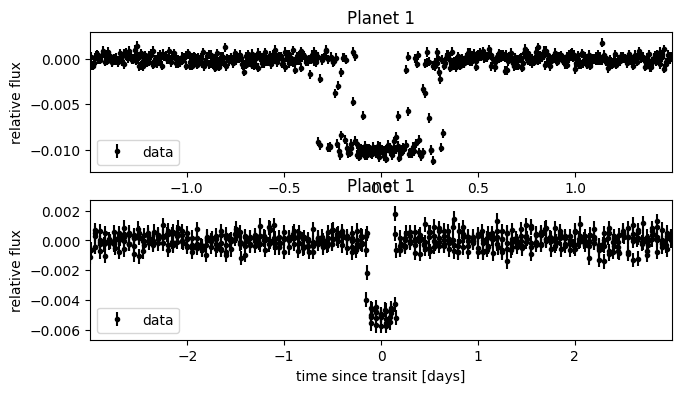

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 4))

map_t0s = [opt_params[f"t0_{i}"] for i in range(2)]
map_periods = [opt_params[f"period_{i}"] for i in range(2)]

for i, (period, t0) in enumerate(zip(map_periods, map_t0s)):
    folded_time = (time - t0 + 0.5 * period) % period - 0.5 * period
    ax[i].errorbar(
        folded_time,
        y - map_light_curve[:, 1 - i],
        yerr=yerr,
        fmt=".k",
        label="data",
        zorder=-1000,
    )
    ax[i].set_xlim(-0.5 * period, 0.5 * period)
    ax[i].set_xlabel("time since transit [days]")
    ax[i].set_ylabel("relative flux")
    ax[i].set_title("Planet 1")
    ax[i].legend()


That obviously doesn't look great, but this is why we need to account for the TTVs, which [TTVOrbit](jaxoplanet.orbits.ttv.TTVOrbit) corrects under the hood.


## Sampling
Let's sample from the posterior.

In [9]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=False,
        regularize_mass_matrix=False,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1), time, yerr, y=y)

sample: 100%|██████████| 1500/1500 [01:23<00:00, 18.02it/s, 63 steps of size 8.42e-02. acc. prob=0.79]


Let's print the summary of our sampling, [as explained here](./transit.ipynb/#checking-our-posterior-samples), focusing on $\hat{R}$ and the number of divergences encountered.

In [10]:
sampler.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             _b[0]      0.29      0.13      0.32      0.07      0.47    110.48      1.00
             _b[1]      0.23      0.16      0.21      0.00      0.46    337.19      1.00
           logD[0]     -0.71      0.01     -0.71     -0.72     -0.69    110.50      1.00
           logD[1]     -1.20      0.02     -1.20     -1.23     -1.17    216.91      1.01
           logR[0]     -2.31      0.01     -2.31     -2.32     -2.30    156.36      1.00
           logR[1]     -2.65      0.01     -2.65     -2.67     -2.64    438.90      1.00
transit_times_0[0]      2.09      0.00      2.09      2.08      2.09    421.27      1.00
transit_times_0[1]      5.12      0.00      5.12      5.12      5.12    249.41      1.00
transit_times_0[2]      8.02      0.00      8.02      8.02      8.03    459.37      1.00
transit_times_0[3]     10.90      0.00     10.90     10.89     10.90    661.28      1.00
transit_times_0[4]  

We can typically plot traces using the `plot_trace` function in the `Arviz` package

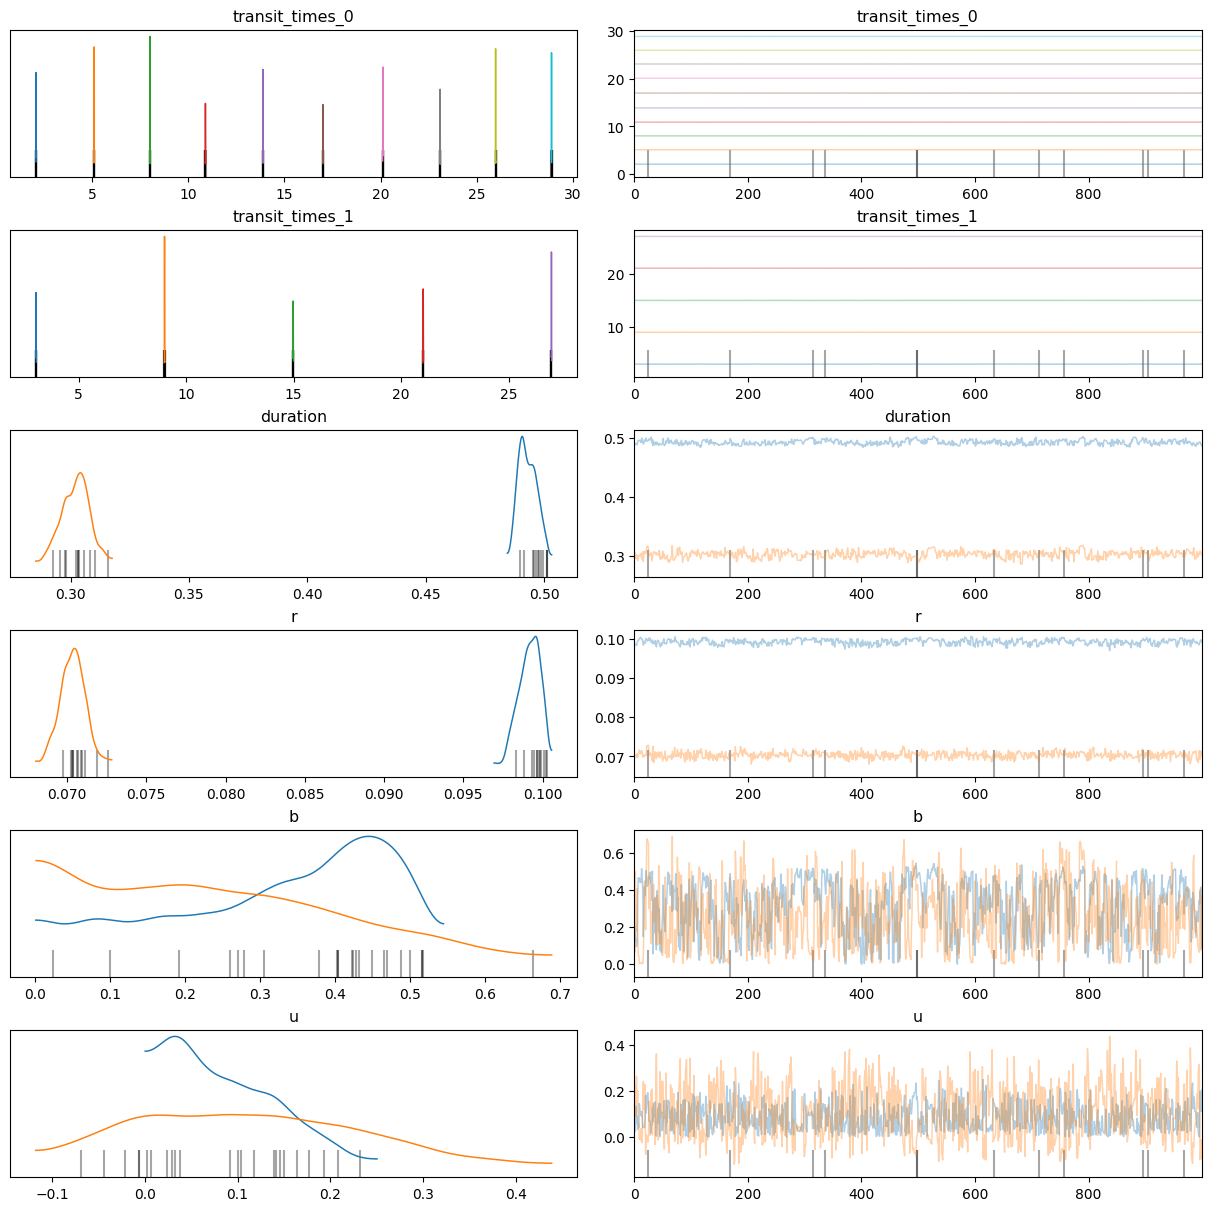

In [11]:
import arviz as az

inf_data = az.from_numpyro(sampler)

az.plot_trace(
    inf_data,
    var_names=["transit_times_0", "transit_times_1", "duration", "r", "b", "u"],
    backend_kwargs={"constrained_layout": True},
)
plt.show()

We have few divergences but not bad overall! Of course, for a real application these divergences must be investigated and the HMC should run on multiple and way longer chains.

# TTV Plots

lets make some TTV plots to show we correctly identified the trend!

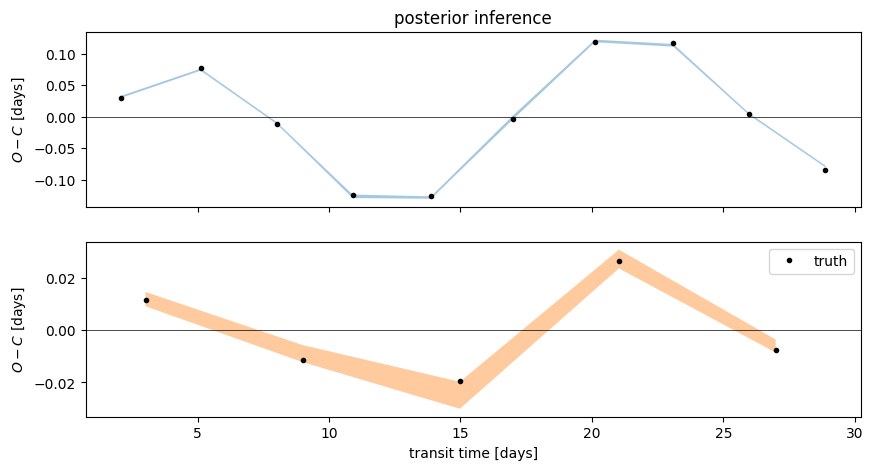

In [12]:
samples = sampler.get_samples()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

q = np.percentile(samples["ttvs_0"], [16, 50, 84], axis=0)

ax1.fill_between(
    np.mean(samples["transit_times_0"], axis=0),
    q[0],
    q[2],
    color="C0",
    alpha=0.4,
    edgecolor="none",
)
ref = np.polyval(
    np.polyfit(true_transit_times[0], true_ttvs[0], 1), true_transit_times[0]
)
ax1.plot(true_transit_times[0], true_ttvs[0] - ref, ".k")
ax1.axhline(0, color="k", lw=0.5)
# ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(samples["ttvs_1"], [16, 50, 84], axis=0)
ax2.fill_between(
    np.mean(samples["transit_times_1"], axis=0),
    q[0],
    q[2],
    color="C1",
    alpha=0.4,
    edgecolor="none",
)
ref = np.polyval(
    np.polyfit(true_transit_times[1], true_ttvs[1], 1), true_transit_times[1]
)
ax2.plot(true_transit_times[1], true_ttvs[1] - ref, ".k", label="truth")
ax2.axhline(0, color="k", lw=0.5)
# ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))

ax2.legend(fontsize=10)
ax2.set_ylabel("$O-C$ [days]")
ax2.set_xlabel("transit time [days]")
_ = ax1.set_title("posterior inference")

We can see the posterior is correctly predicting the true ttvs!